dataset link: https://www.kaggle.com/datasets/gpiosenka/100-bird-species 
run the project in the kaggle        

In [1]:
import numpy as np
np.random.seed(11)

import pandas as pd 
import tensorflow as tf
import tensorflow_addons as tfa
import os

from tensorflow.keras import layers, optimizers, losses, metrics, callbacks, initializers
from tensorflow.keras import Sequential, Model, Input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from PIL import Image

In [6]:
TRAIN = 'C:/Users/User/Downloads/data set checking/JPDL20-Bird Species Identification/SOURCE CODE/Bird Species Identification/model/train/'
VALID = 'C:/Users/User/Downloads/data set checking/JPDL20-Bird Species Identification/SOURCE CODE/Bird Species Identification/model/valid/'
TEST = 'C:/Users/User/Downloads/data set checking/JPDL20-Bird Species Identification/SOURCE CODE/Bird Species Identification/model/test/'

In [7]:
datagen= ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_directory(
    directory=TRAIN,
    batch_size=64,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224))

valid_generator=datagen.flow_from_directory(
    directory=VALID,
    batch_size=64,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224))

test_generator=datagen.flow_from_directory(
    directory=TEST,
    batch_size=64,
    shuffle=False,
    class_mode="categorical",
    target_size=(224, 224))

Found 81950 images belonging to 510 classes.
Found 2550 images belonging to 510 classes.
Found 2550 images belonging to 510 classes.


In [4]:
from tensorflow.keras.applications.xception import Xception

base_model = Xception(include_top = False, input_shape = (224,224,3), weights = 'imagenet')

base_model.trainable = False

inputs = Input(shape=(224,224,3))
main = base_model(inputs, training = False)

x = layers.GlobalMaxPooling2D()(main)
x = layers.Dense(256, 'relu', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(400, activation='softmax', name= 'outputs')(x)

model = Model(inputs= [inputs], outputs= [outputs])

reducer = callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    patience=1, 
    verbose=1, 
    factor=0.1)

model.compile(optimizer=optimizers.Adam(0.001), 
              metrics=[metrics.CategoricalAccuracy(name='accuracy'), tfa.metrics.F1Score(400), metrics.TopKCategoricalAccuracy(k=5)], 
              loss=losses.CategoricalCrossentropy(label_smoothing=0.1))

model.summary()

2022-03-30 02:42:42.213494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 02:42:42.331791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 02:42:42.332545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 02:42:42.334026: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
______________________________________________________________

In [5]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    callbacks= reducer,
                    epochs=10)

2022-03-30 02:42:47.133673: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-03-30 02:42:51.543316: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


913/913 [==============================] - 424s 454ms/step - loss: 2.5922 - accuracy: 0.6074 - f1_score: 0.6025 - top_k_categorical_accuracy: 0.8269 - val_loss: 1.7066 - val_accuracy: 0.8405 - val_f1_score: 0.8328 - val_top_k_categorical_accuracy: 0.9690
Epoch 2/10
913/913 [==============================] - 204s 223ms/step - loss: 1.8206 - accuracy: 0.8012 - f1_score: 0.7995 - top_k_categorical_accuracy: 0.9530 - val_loss: 1.6036 - val_accuracy: 0.8665 - val_f1_score: 0.8637 - val_top_k_categorical_accuracy: 0.9795
Epoch 3/10
913/913 [==============================] - 204s 223ms/step - loss: 1.7090 - accuracy: 0.8370 - f1_score: 0.8354 - top_k_categorical_accuracy: 0.9657 - val_loss: 1.5422 - val_accuracy: 0.8800 - val_f1_score: 0.8773 - val_top_k_categorical_accuracy: 0.9875
Epoch 4/10
913/913 [==============================] - 206s 225ms/step - loss: 1.6500 - accuracy: 0.8556 - f1_score: 0.8546 - top_k_categorical_accuracy: 0.9724 - val_loss: 1.5348 - val_accuracy: 0.8750 - val_f1_sc

In [7]:
base_model = model.layers[1]
base_model.trainable = True

for  layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer = optimizers.Adam(0.0001), 
              metrics=[metrics.CategoricalAccuracy(name='accuracy'), tfa.metrics.F1Score(400), metrics.TopKCategoricalAccuracy(k=5)], 
              loss=losses.CategoricalCrossentropy(label_smoothing=0.1))

checkpoint = callbacks.ModelCheckpoint(
    filepath='birds_fine.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode = 'max')

history_fine = model.fit(train_generator,
                         epochs=20,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_generator,
                         callbacks= checkpoint)

Epoch 10/20
913/913 [==============================] - 220s 238ms/step - loss: 1.4055 - accuracy: 0.9313 - f1_score: 0.9312 - top_k_categorical_accuracy: 0.9911 - val_loss: 1.2769 - val_accuracy: 0.9545 - val_f1_score: 0.9537 - val_top_k_categorical_accuracy: 0.9960

Epoch 00010: val_accuracy improved from -inf to 0.95450, saving model to birds_fine.h5
Epoch 11/20
913/913 [==============================] - 219s 239ms/step - loss: 1.2929 - accuracy: 0.9649 - f1_score: 0.9648 - top_k_categorical_accuracy: 0.9970 - val_loss: 1.2510 - val_accuracy: 0.9650 - val_f1_score: 0.9647 - val_top_k_categorical_accuracy: 0.9960

Epoch 00011: val_accuracy improved from 0.95450 to 0.96500, saving model to birds_fine.h5
Epoch 12/20
913/913 [==============================] - 220s 240ms/step - loss: 1.2325 - accuracy: 0.9812 - f1_score: 0.9812 - top_k_categorical_accuracy: 0.9989 - val_loss: 1.2173 - val_accuracy: 0.9670 - val_f1_score: 0.9666 - val_top_k_categorical_accuracy: 0.9965

Epoch 00012: val_ac

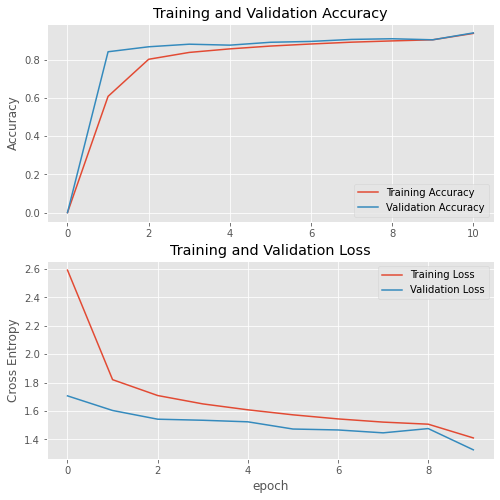

In [8]:
 acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [9]:
model.evaluate(test_generator)

32/32 [==============================] - 16s 504ms/step - loss: 1.0885 - accuracy: 0.9910 - f1_score: 0.9910 - top_k_categorical_accuracy: 0.9980


[1.0885026454925537,
 0.9909999966621399,
 array([1.        , 0.88888896, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.88888896, 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.90909094, 0.88888896, 1.        ,
        0.88888896, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.8000001 , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.90909094, 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.90909094, 1.        , 1.        ,
        1.        , 1.        , 0.90909094, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
      